<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Detection-Classficiation-CNN/Generating_Annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HD-BET Installation

In [18]:
!git clone https://github.com/MIC-DKFZ/HD-BET.git
%cd HD-BET
!pip install -r requirements.txt
%cd ..

fatal: destination path 'HD-BET' already exists and is not an empty directory.
/content/HD-BET
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
/content


Import Required Libraires

In [19]:
!pip install --upgrade tensorflow==2.18.0 segmentation-models==1.0.1 tensorflow-hub tensorflow-addons opencv-python scikit-learn kagglehub
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow.keras as keras
print("tf.keras is available.")

import segmentation_models as sm
import glob
import random
import cv2
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import uuid
import shutil
import subprocess
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString

drive.mount('/content/drive')

Found existing installation: protobuf 3.20.3
Uninstalling protobuf-3.20.3:
  Successfully uninstalled protobuf-3.20.3
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


TensorFlow version: 2.18.0
tf.keras is available.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Paths

In [20]:
RAW_DATASET_PATH = "/content/drive/MyDrive/DSGP/DSGP_dataset"
tumor_classes = [folder for folder in os.listdir(RAW_DATASET_PATH)
                 if os.path.isdir(os.path.join(RAW_DATASET_PATH, folder))]
print("Detected classes:", tumor_classes)

Detected classes: ['no_tumour', 'tumour']


Preprocessing Functions

In [21]:
TARGET_SIZE = (256, 256)

def preprocess_image(img_path, target_size=TARGET_SIZE):
    """Load an image, convert to RGB, resize, and normalize."""
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_norm = img_resized.astype(np.float32) / 255.0
    return img_norm

def run_hdbet(input_file, output_dir="hd_bet_out", device="cpu", mode="fast"):
    """Run HD-BET on a given input file."""
    os.makedirs(output_dir, exist_ok=True)
    cmd = [
        "python", "HD-BET/hd-bet.py",
        "-i", input_file,
        "-o", output_dir,
        "-device", device,
        "-mode", mode
    ]
    subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    base = os.path.basename(input_file)
    if base.endswith(".nii.gz"):
        base = base[:-7]
    elif base.endswith(".nii"):
        base = base[:-4]
    output_file = os.path.join(output_dir, base + "_brain.nii.gz")
    if os.path.exists(output_file):
        return output_file
    else:
        raise FileNotFoundError("HD-BET output not found:", output_file)

def generate_bbox_from_mask(mask, threshold=0.7, min_area=500):
    """
    Convert a segmentation mask to bounding box coordinates using connected components.
    Returns None if the largest component's area is below min_area.
    """
    mask = np.squeeze(mask)  # Ensure mask is 2D
    bin_mask = (mask > threshold).astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    bin_mask = cv2.morphologyEx(bin_mask, cv2.MORPH_OPEN, kernel)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(bin_mask, connectivity=8)
    if num_labels <= 1:
        return None
    max_label = 1
    max_area = stats[1, cv2.CC_STAT_AREA]
    for i in range(2, num_labels):
        if stats[i, cv2.CC_STAT_AREA] > max_area:
            max_area = stats[i, cv2.CC_STAT_AREA]
            max_label = i
    if max_area < min_area:
        return None
    x = stats[max_label, cv2.CC_STAT_LEFT]
    y = stats[max_label, cv2.CC_STAT_TOP]
    w = stats[max_label, cv2.CC_STAT_WIDTH]
    h = stats[max_label, cv2.CC_STAT_HEIGHT]
    return [x, y, x+w, y+h]

def create_pascal_voc_xml(image_path, bbox, label, save_dir):
    """Generate a PASCAL VOC XML annotation file."""
    image_name = os.path.basename(image_path)
    xml_filename = os.path.splitext(image_name)[0] + ".xml"
    root = ET.Element("annotation")
    ET.SubElement(root, "filename").text = image_name
    size = ET.SubElement(root, "size")
    ET.SubElement(size, "width").text = str(TARGET_SIZE[0])
    ET.SubElement(size, "height").text = str(TARGET_SIZE[1])
    obj = ET.SubElement(root, "object")
    ET.SubElement(obj, "name").text = label
    bbox_elem = ET.SubElement(obj, "bndbox")
    for tag, value in zip(["xmin", "ymin", "xmax", "ymax"], bbox):
        ET.SubElement(bbox_elem, tag).text = str(value)
    xml_str = parseString(ET.tostring(root)).toprettyxml()
    with open(os.path.join(save_dir, xml_filename), "w") as f:
        f.write(xml_str)

Loading U-Net Model

In [22]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (keras.backend.sum(y_true_f) + keras.backend.sum(y_pred_f) + smooth)

unet_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/DSGP/U-Net model/U-Net.h5",
    custom_objects={"dice_coefficient": dice_coefficient}
)

Preproceesing Dataset

In [23]:
def process_dataset_for_detection(raw_dataset_path, output_images_dir, output_ann_dir, unet_model, hd_bet=True):
    """
    For each image in the raw dataset (organized in folders 'tumour' and 'no_tumour'),
    perform preprocessing, optionally run skull stripping with HD-BET, generate segmentation masks
    using the U-Net model, convert masks to bounding boxes, and save preprocessed images and
    annotations (PASCAL VOC XML) for detection training.
    """
    classes = [folder for folder in os.listdir(raw_dataset_path)
               if os.path.isdir(os.path.join(raw_dataset_path, folder))]
    for cls in classes:
        class_dir = os.path.join(raw_dataset_path, cls)
        image_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        img_out_dir = os.path.join(output_images_dir, cls)
        ann_out_dir = os.path.join(output_ann_dir, cls)
        os.makedirs(img_out_dir, exist_ok=True)
        os.makedirs(ann_out_dir, exist_ok=True)

        for image_path in image_files:
            image = preprocess_image(image_path)
            if hd_bet:
                try:
                    skull_stripped_path = run_hdbet(image_path, output_dir="hd_bet_out", device="cpu", mode="fast")
                    image = preprocess_image(skull_stripped_path)
                except Exception as e:
                    pass

            img_resized = tf.image.resize(image, TARGET_SIZE)
            img_batch = tf.expand_dims(img_resized, axis=0)
            mask = unet_model.predict(img_batch, verbose=0)[0]  # shape (256,256,1)
            bbox = generate_bbox_from_mask(mask, threshold=0.5)
            if bbox is None:
                if cls.lower() in ["tumour", "tumor"]:
                    continue
                else:
                    bbox = [0, 0, TARGET_SIZE[0], TARGET_SIZE[1]]

            img_save = (image * 255).astype(np.uint8)
            img_save = cv2.resize(img_save, TARGET_SIZE)
            img_save_path = os.path.join(img_out_dir, os.path.basename(image_path))
            Image.fromarray(img_save).save(img_save_path)
            create_pascal_voc_xml(image_path, bbox, cls, ann_out_dir)

Run Preprocessing

In [24]:
OUTPUT_IMAGES_PATH = "/content/drive/MyDrive/DSGP/Detection_Images"
OUTPUT_ANN_PATH = "/content/drive/MyDrive/DSGP/Detection_Annotations"

process_dataset_for_detection(
    RAW_DATASET_PATH,
    OUTPUT_IMAGES_PATH,
    OUTPUT_ANN_PATH,
    unet_model,
    hd_bet=False  # For PNG/JPG images, set hd_bet to False.
)

Augmentation

In [25]:
def augment_and_generate_annotation(image_path, save_img_dir, save_ann_dir, unet_model, label, count=1):
    """
    Augment a single image, run U-Net on the augmented image to generate a new annotation,
    and save the augmented image and its annotation.
    """
    image = preprocess_image(image_path)
    image_expanded = np.expand_dims(image, axis=0)
    generated_names = []
    for i in range(count):
        aug_img = next(augmentor.flow(image_expanded, batch_size=1, shuffle=False))[0]
        aug_img_uint8 = (aug_img * 255).astype(np.uint8)
        new_name = f"{label}_aug_{uuid.uuid4()}.png"
        save_path = os.path.join(save_img_dir, new_name)
        cv2.imwrite(save_path, cv2.cvtColor(aug_img_uint8, cv2.COLOR_RGB2BGR))
        generated_names.append(new_name)
        # Generate annotation for the augmented image
        img_resized = tf.image.resize(aug_img, TARGET_SIZE)
        img_batch = tf.expand_dims(img_resized, axis=0)
        mask = unet_model.predict(img_batch, verbose=0)[0]
        bbox = generate_bbox_from_mask(mask, threshold=0.5)
        if bbox is None:
            if label.lower() in ["tumour", "tumor"]:
                continue
            else:
                bbox = [0, 0, TARGET_SIZE[0], TARGET_SIZE[1]]
        # Save annotation: Here we use new_name to name the XML file.
        # We pass the original image_path for filename in XML, but you may want to update that.
        create_pascal_voc_xml(image_path, bbox, label, save_ann_dir)
    return generated_names

Split Dataset

In [26]:
def split_and_balance_class(class_name, orig_img_dir, orig_ann_dir, output_dir,
                              train_count=4000, total_count=5000, seed=42, unet_model=None):
    random.seed(seed)
    orig_images = [f for f in os.listdir(orig_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(orig_images)

    available = len(orig_images)
    # Use all available originals for training if fewer than train_count
    if available < train_count:
        print(f"Not enough original images for {class_name} for training (found {available}). Using all as training.")
        train_imgs = orig_images[:]
    else:
        train_imgs = orig_images[:train_count]

    required_remainder = total_count - len(train_imgs)  # needed for Test+Val
    remainder = [f for f in orig_images if f not in train_imgs]

    if len(remainder) < required_remainder:
        to_augment = required_remainder - len(remainder)
        print(f"{class_name}: Augmenting {to_augment} images for Test+Val.")
        for _ in range(to_augment):
            chosen = random.choice(orig_images)
            augment_and_generate_annotation(
                os.path.join(orig_img_dir, chosen),
                orig_img_dir,
                orig_ann_dir,
                unet_model,
                class_name,
                count=1
            )
        all_imgs = [f for f in os.listdir(orig_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        remainder = [f for f in all_imgs if f not in train_imgs]
        remainder = remainder[:required_remainder]
    else:
        remainder = remainder[:required_remainder]

    half = required_remainder // 2
    test_imgs = remainder[:half]
    val_imgs = remainder[half:half*2]

    for split, file_list in zip(["Train", "Val", "Test"], [train_imgs, val_imgs, test_imgs]):
        img_out_dir = os.path.join(output_dir, split, "Images", class_name)
        ann_out_dir = os.path.join(output_dir, split, "Annotations", class_name)
        os.makedirs(img_out_dir, exist_ok=True)
        os.makedirs(ann_out_dir, exist_ok=True)
        for filename in file_list:
            shutil.copy(os.path.join(orig_img_dir, filename), img_out_dir)
            xml_filename = os.path.splitext(filename)[0] + ".xml"
            src_xml = os.path.join(orig_ann_dir, xml_filename)
            if os.path.exists(src_xml):
                shutil.copy(src_xml, ann_out_dir)
            else:
                print(f"Warning: Annotation not found for {filename} in {class_name}")

    print(f"{class_name} split: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

OUTPUT_SPLIT_DIR = "/content/drive/MyDrive/DSGP/Detection_Split"

for cls in tumor_classes:
    orig_img_dir = os.path.join(OUTPUT_IMAGES_PATH, cls)
    orig_ann_dir = os.path.join(OUTPUT_ANN_PATH, cls)
    print(f"Splitting and balancing class: {cls}")
    split_and_balance_class(cls, orig_img_dir, orig_ann_dir, OUTPUT_SPLIT_DIR,
                              train_count=4000, total_count=5000, seed=42, unet_model=unet_model)

Splitting and balancing class: no_tumour
no_tumour: Augmenting 1000 images for Test+Val.
no_tumour split: Train=4000, Val=500, Test=500
Splitting and balancing class: tumour
Not enough original images for tumour for training (found 3136). Using all as training.
tumour: Augmenting 1864 images for Test+Val.
tumour split: Train=3136, Val=932, Test=932


Verify Dataset Split

In [27]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

for split in ["Train", "Val", "Test"]:
    print(f"\nSplit: {split}")
    for cls in tumor_classes:
        img_dir = os.path.join(OUTPUT_SPLIT_DIR, split, "Images", cls)
        ann_dir = os.path.join(OUTPUT_SPLIT_DIR, split, "Annotations", cls)
        print(f"  Class {cls}: {count_images(img_dir)} images, {count_images(ann_dir)} annotations")


Split: Train
  Class no_tumour: 4000 images, 0 annotations
  Class tumour: 3136 images, 0 annotations

Split: Val
  Class no_tumour: 500 images, 0 annotations
  Class tumour: 932 images, 0 annotations

Split: Test
  Class no_tumour: 500 images, 0 annotations
  Class tumour: 932 images, 0 annotations


Plot Class Distributions

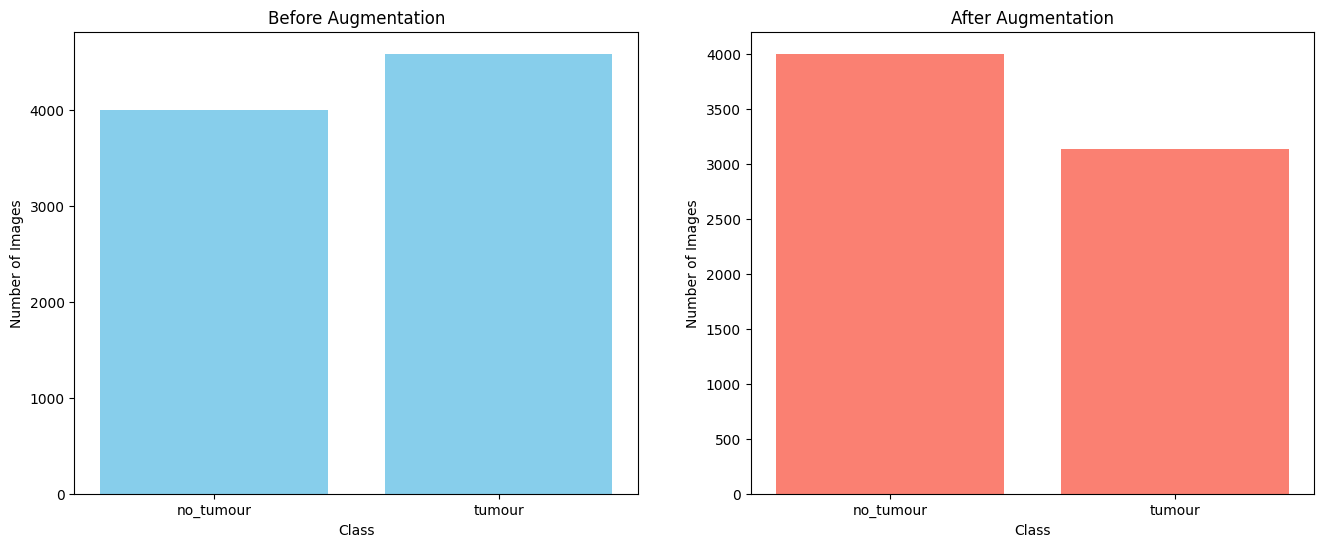

In [28]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

before_counts = {cls: count_images(os.path.join(RAW_DATASET_PATH, cls)) for cls in tumor_classes}
after_counts = {cls: count_images(os.path.join(OUTPUT_SPLIT_DIR, "Train", "Images", cls)) for cls in tumor_classes}

fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].bar(before_counts.keys(), before_counts.values(), color="skyblue")
axes[0].set_title("Before Augmentation")
axes[0].set_ylabel("Number of Images")
axes[0].set_xlabel("Class")

axes[1].bar(after_counts.keys(), after_counts.values(), color="salmon")
axes[1].set_title("After Augmentation")
axes[1].set_ylabel("Number of Images")
axes[1].set_xlabel("Class")
plt.show()

Visualizing Examples

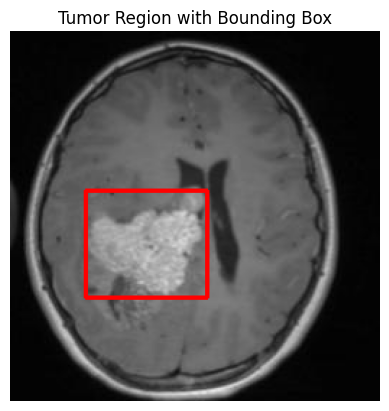

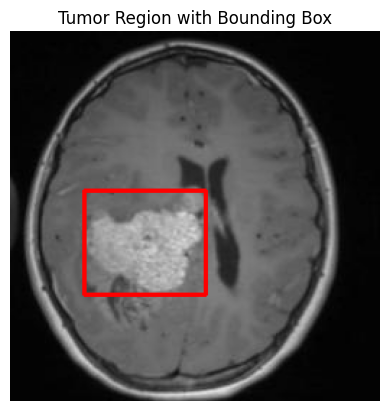

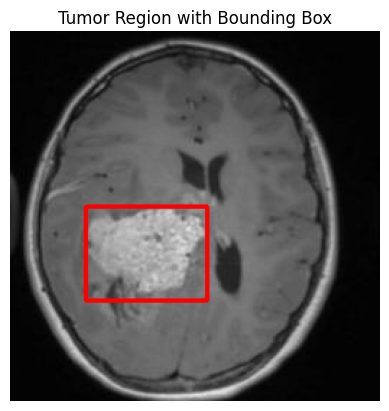

Error: Image file not found: /content/drive/MyDrive/DSGP/Detection_Images/no_tumour/Tr-noTr_0006.png


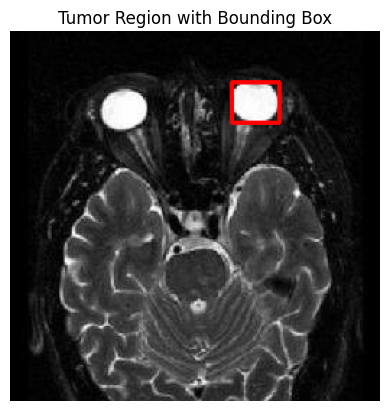

Error: Image file not found: /content/drive/MyDrive/DSGP/Detection_Images/no_tumour/Tr-noTr_1593.jpg


In [29]:
def visualize_tumor_with_bbox(image_path, unet_model):
    if not os.path.exists(image_path):
        print(f"Error: Image file not found: {image_path}")
        return
    image = preprocess_image(image_path)
    img_resized = tf.image.resize(image, TARGET_SIZE)
    img_batch = tf.expand_dims(img_resized, axis=0)
    mask = unet_model.predict(img_batch, verbose=0)[0]
    bbox = generate_bbox_from_mask(mask, threshold=0.5)
    disp_img = (image * 255).astype(np.uint8)
    disp_img = cv2.resize(disp_img, TARGET_SIZE)
    if bbox is not None:
        cv2.rectangle(disp_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    plt.imshow(disp_img)
    plt.title("Tumor Region with Bounding Box")
    plt.axis("off")
    plt.show()

# Visualize example images (update paths as needed)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/z.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
# Visualize example images (update paths as needed)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/x.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
# Visualize example images (update paths as needed)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/tumour/v.jpeg"
visualize_tumor_with_bbox(example_image, unet_model)
# Visualize example images (update paths as needed)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/no_tumour/Tr-noTr_0006.png"
visualize_tumor_with_bbox(example_image, unet_model)
# Visualize example images (update paths as needed)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/no_tumour/Tr-noTr_0001.jpg"
visualize_tumor_with_bbox(example_image, unet_model)
# Visualize example images (update paths as needed)
example_image = "/content/drive/MyDrive/DSGP/Detection_Images/no_tumour/Tr-noTr_1593.jpg"
visualize_tumor_with_bbox(example_image, unet_model)